In [87]:
import numpy as np
import pandas as pd
import sklearn as sk

# Read files
train_data = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')

In [88]:
# Drop unneeded columns
cols_to_drop = ['Cabin', 'Name', 'Ticket']
train_data = train_data.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)
train_data = train_data.drop("PassengerId", axis=1)

In [89]:

DataFrame = None
Columns = []
def PandasOneHotEncodeNumpy(DataFrame, Columns):
    OutNumpyMat = None
    columnNames = []
    
    for col in Columns:
        unique_values = sorted(DataFrame[col].unique())
        one_hot = (DataFrame[col].values[:, None] == unique_values).astype(int)
        one_hot = one_hot[:, :-1]
        
        if OutNumpyMat is None:
            OutNumpyMat = one_hot
        else:
            OutNumpyMat = np.hstack((OutNumpyMat, one_hot))
        
        columnNames.extend([f"{col}_{val}" for val in unique_values[:-1]])
    
    return OutNumpyMat, columnNames

In [90]:
# One hot encode using custom function
def one_hot_encode_sex_embarked(df):
    # Remove rows where Embarked is NaN
    df = df.dropna(subset=['Embarked'])
    
    # Use custom one-hot encoding function
    encoded_matrix, column_names = PandasOneHotEncodeNumpy(df, ['Sex', 'Embarked'])
    
    # Create DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_matrix, columns=column_names, index=df.index)
    
    # Drop original categorical columns and add encoded ones
    df_encoded = df.drop(columns=['Sex', 'Embarked'])
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    return df_encoded

In [91]:
# Fill missing ages with median age
def fill_missing_ages(df):
    median_age = df['Age'].median()
    df['Age'] = df['Age'].fillna(median_age)
    return df

In [92]:
# Normalize features
def normalize_features(df, minmax_cols, standard_cols, fit_stats=None):
    df_norm = df.copy()
    if fit_stats is None:
        fit_stats = {}
        for col in minmax_cols:
            fit_stats[col] = {
                'min': df_norm[col].min(),
                'max': df_norm[col].max()
            }
        for col in standard_cols:
            fit_stats[col] = {
                'mean': df_norm[col].mean(),
                'std': df_norm[col].std()
            }
    for col in minmax_cols:
        min_val = fit_stats[col]['min']
        max_val = fit_stats[col]['max']
        df_norm[col] = (df_norm[col] - min_val) / (max_val - min_val)
    for col in standard_cols:
        mean = fit_stats[col]['mean']
        std = fit_stats[col]['std']
        df_norm[col] = (df_norm[col] - mean) / std
    if fit_stats is not None:
        return df_norm, fit_stats
    else:
        return df_norm
    
# One hot encode and fill missing ages
train_data = one_hot_encode_sex_embarked(train_data)
test_df = one_hot_encode_sex_embarked(test_df)
train_data = fill_missing_ages(train_data)
test_df = fill_missing_ages(test_df)


# Normalize features
minmax_cols = ['Pclass','Fare','Age', 'SibSp', 'Parch']
standard_cols = []
fit_stats = {}
train_data, fit_stats = normalize_features(train_data, minmax_cols, standard_cols)
test_df, _ = normalize_features(test_df, minmax_cols, standard_cols, fit_stats)


In [93]:


# Finish preparing data
# The categorical columns are already encoded using our custom function
X = train_data.drop("Survived", axis=1).values.astype(float)
y = train_data["Survived"].values.reshape(-1, 1).astype(float)

In [94]:
#Split data into training and validation sets
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_df.drop("PassengerId", axis=1).values.astype(float)

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Define the pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_dist = {
    'clf__n_estimators': [10, 50, 100, 200, 400, 800],
    'clf__bootstrap': [True, False],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_depth': [None, 5, 10, 20, 40, 80],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Setup RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# Fit on training data
search.fit(X_train, y_train.ravel())

# Validation accuracy
print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)
print("Validation accuracy:", search.score(X_val, y_val))

Best parameters: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__bootstrap': False}
Best cross-validation score: 0.8466947960618847
Validation accuracy: 0.7808988764044944


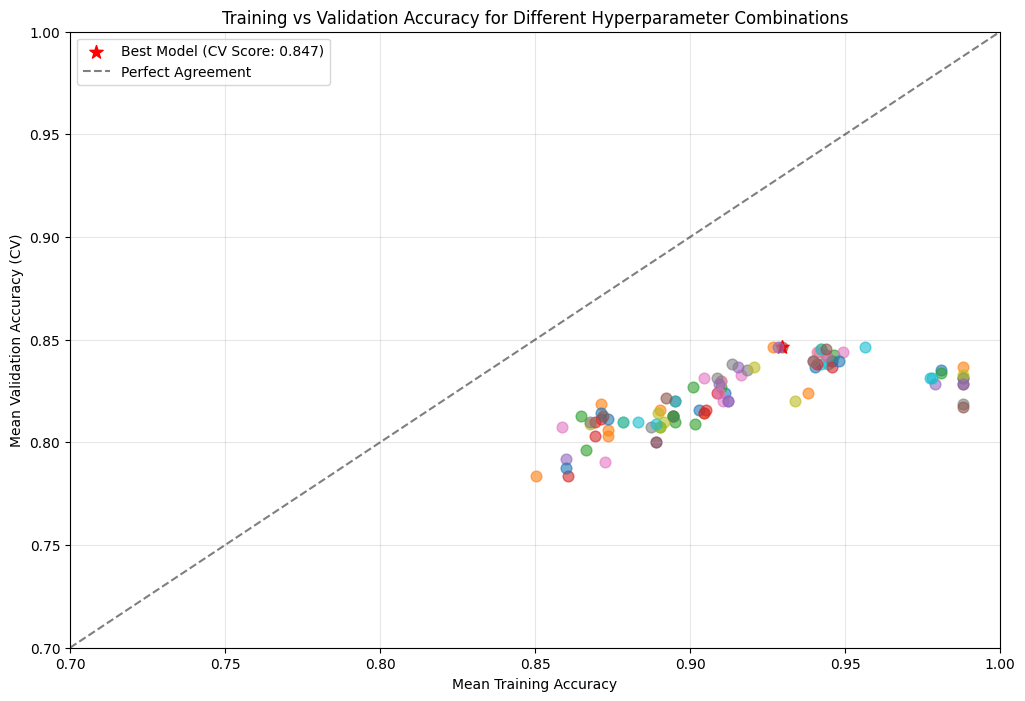


Top 5 Models by Cross-Validation Score:
Model 1: CV Score = 0.8467, Params = {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__bootstrap': False}
Model 2: CV Score = 0.8467, Params = {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__bootstrap': False}
Model 3: CV Score = 0.8467, Params = {'clf__n_estimators': 800, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__bootstrap': False}
Model 4: CV Score = 0.8467, Params = {'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10, 'clf__bootstrap': False}
Model 5: CV Score = 0.8453, Params = {'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_depth': 20, 'clf__bootstrap': False}


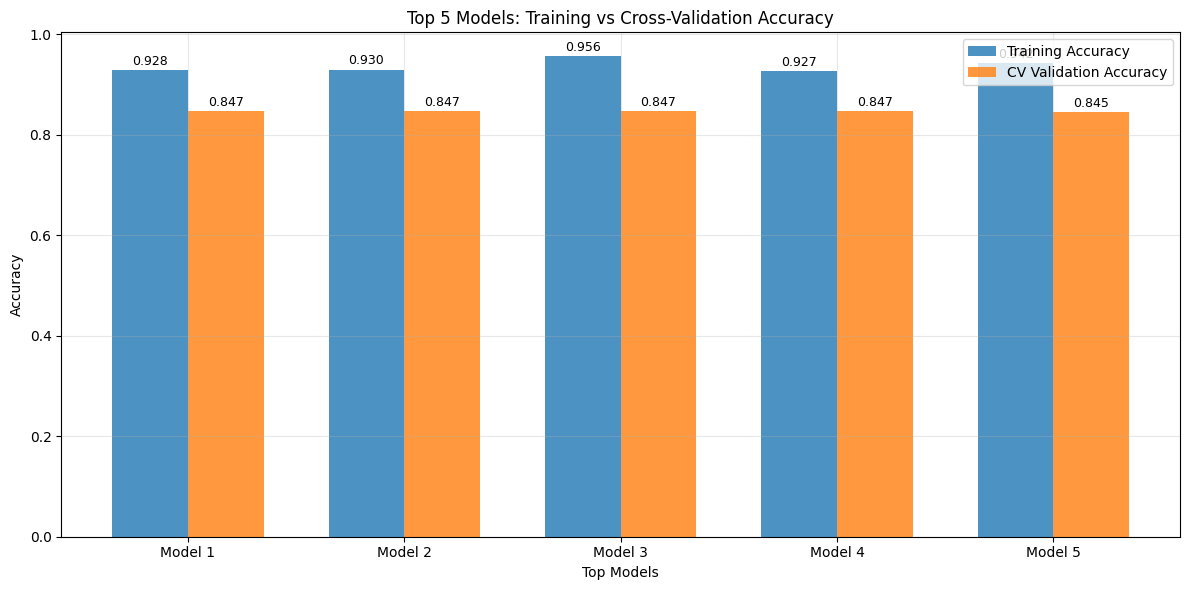

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results from RandomizedSearchCV
train_scores = search.cv_results_['mean_train_score']
val_scores = search.cv_results_['mean_test_score']
params = search.cv_results_['params']

# Create a scatter plot showing train vs validation accuracy for each combination
plt.figure(figsize=(12, 8))

# Plot each point
for i, (train_acc, val_acc, param_set) in enumerate(zip(train_scores, val_scores, params)):
    plt.scatter(train_acc, val_acc, alpha=0.6, s=60)
    
    # Annotate the best performing point
    if i == search.best_index_:
        plt.scatter(train_acc, val_acc, color='red', s=100, marker='*', 
                   label=f'Best Model (CV Score: {search.best_score_:.3f})')

# Add diagonal line (perfect agreement between train and validation)
plt.plot([0.7, 1.0], [0.7, 1.0], 'k--', alpha=0.5, label='Perfect Agreement')

plt.xlabel('Mean Training Accuracy')
plt.ylabel('Mean Validation Accuracy (CV)')
plt.title('Training vs Validation Accuracy for Different Hyperparameter Combinations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.7, 1.0)
plt.ylim(0.7, 1.0)
plt.show()

# Also create a bar chart showing top 5 models
print("\nTop 5 Models by Cross-Validation Score:")
top_indices = np.argsort(val_scores)[-5:][::-1]

plt.figure(figsize=(12, 6))
model_names = [f"Model {i+1}" for i in range(5)]
top_train_scores = [train_scores[i] for i in top_indices]
top_val_scores = [val_scores[i] for i in top_indices]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, top_train_scores, width, label='Training Accuracy', alpha=0.8)
plt.bar(x + width/2, top_val_scores, width, label='CV Validation Accuracy', alpha=0.8)

plt.xlabel('Top Models')
plt.ylabel('Accuracy')
plt.title('Top 5 Models: Training vs Cross-Validation Accuracy')
plt.xticks(x, model_names)
plt.legend()
plt.grid(True, alpha=0.3)

for i, idx in enumerate(top_indices):
    print(f"Model {i+1}: CV Score = {val_scores[idx]:.4f}, Params = {params[idx]}")
    plt.text(i - width/2, top_train_scores[i] + 0.005, f'{top_train_scores[i]:.3f}', 
             ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, top_val_scores[i] + 0.005, f'{top_val_scores[i]:.3f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


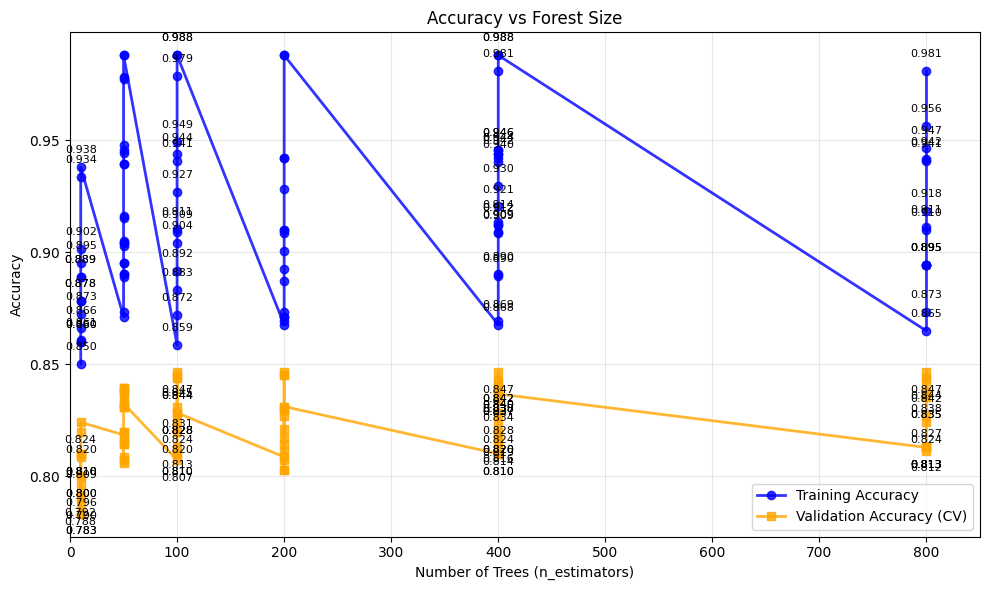

Forest Size Analysis:
----------------------------------------
Best Validation Accuracy: 0.8467 at 100 trees
Training Accuracy at Best: 0.9269
Overfitting Gap: 0.0802

All Results (sorted by forest size):
Trees:  10 | Train: 0.8502 | Val: 0.7834 | Gap: 0.0668
Trees:  10 | Train: 0.8601 | Val: 0.7876 | Gap: 0.0724
Trees:  10 | Train: 0.8601 | Val: 0.7918 | Gap: 0.0682
Trees:  10 | Train: 0.8608 | Val: 0.7834 | Gap: 0.0774
Trees:  10 | Train: 0.8664 | Val: 0.7961 | Gap: 0.0703
Trees:  10 | Train: 0.8727 | Val: 0.7904 | Gap: 0.0823
Trees:  10 | Train: 0.8783 | Val: 0.8101 | Gap: 0.0682
Trees:  10 | Train: 0.8783 | Val: 0.8101 | Gap: 0.0682
Trees:  10 | Train: 0.8889 | Val: 0.8003 | Gap: 0.0886
Trees:  10 | Train: 0.8889 | Val: 0.8003 | Gap: 0.0886
Trees:  10 | Train: 0.8952 | Val: 0.8101 | Gap: 0.0851
Trees:  10 | Train: 0.9015 | Val: 0.8087 | Gap: 0.0928
Trees:  10 | Train: 0.9339 | Val: 0.8200 | Gap: 0.1139
Trees:  10 | Train: 0.9381 | Val: 0.8242 | Gap: 0.1139
Trees:  50 | Train: 0.871

In [99]:
# Generate Accuracy vs Forest Size plot
import matplotlib.pyplot as plt
import numpy as np

# Extract n_estimators and corresponding scores from the search results
n_estimators_list = []
train_acc_list = []
val_acc_list = []

for i, param_set in enumerate(search.cv_results_['params']):
    n_estimators_list.append(param_set['clf__n_estimators'])
    train_acc_list.append(search.cv_results_['mean_train_score'][i])
    val_acc_list.append(search.cv_results_['mean_test_score'][i])

# Sort by n_estimators for cleaner plotting
sorted_data = sorted(zip(n_estimators_list, train_acc_list, val_acc_list))
n_estimators_sorted, train_sorted, val_sorted = zip(*sorted_data)

# Create the Accuracy vs Forest Size plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_sorted, train_sorted, label='Training Accuracy', 
         marker='o', markersize=6, linewidth=2, alpha=0.8, color='blue')
plt.plot(n_estimators_sorted, val_sorted, label='Validation Accuracy (CV)', 
         marker='s', markersize=6, linewidth=2, alpha=0.8, color='orange')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Forest Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, max(n_estimators_sorted) + 50)

# Add text annotations for key points
for i, (n_est, train_acc, val_acc) in enumerate(zip(n_estimators_sorted, train_sorted, val_sorted)):
    if n_est in [10, 100, 400, 800]:  # Annotate key forest sizes
        plt.annotate(f'{train_acc:.3f}', (n_est, train_acc), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        plt.annotate(f'{val_acc:.3f}', (n_est, val_acc), 
                    textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print forest size analysis
print("Forest Size Analysis:")
print("-" * 40)
best_idx = np.argmax(val_sorted)
print(f"Best Validation Accuracy: {val_sorted[best_idx]:.4f} at {n_estimators_sorted[best_idx]} trees")
print(f"Training Accuracy at Best: {train_sorted[best_idx]:.4f}")
print(f"Overfitting Gap: {train_sorted[best_idx] - val_sorted[best_idx]:.4f}")
print("\nAll Results (sorted by forest size):")
for n_est, train_acc, val_acc in zip(n_estimators_sorted, train_sorted, val_sorted):
    print(f"Trees: {n_est:3d} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Gap: {train_acc-val_acc:.4f}")

In [98]:



# output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': y_test_pred.flatten()})
# output.to_csv('submission.csv', index=False)

